In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score, recall_score, precision_score, roc_auc_score,roc_curve




In [2]:
with open('Dataset_After_Preprocessing.pkl', 'rb') as f:
    Dataset_After_Preprocessing = pickle.load(f)

In [3]:

# Memisahkan fitur dan target
X = Dataset_After_Preprocessing.drop(columns=['Exited'])
y = Dataset_After_Preprocessing['Exited']

# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train is:", X_train.shape)
print("Shape of X_test is:", X_test.shape)
print("Shape of y_train is:", y_train.shape)
print("Shape of y_test is:", y_test.shape)

# Mengubah tipe data target menjadi integer
y_train = y_train.astype('int')
y_test = y_test.astype('int')


Shape of X_train is: (12545, 16)
Shape of X_test is: (3137, 16)
Shape of y_train is: (12545,)
Shape of y_test is: (3137,)


In [4]:

# jika target memerlukan encoding
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

# pemilihan model, misal menggunakan Random Forest
rfc = RandomForestClassifier(random_state=42)

# Cross Validation
cv_scores = cross_val_score(rfc, X_train, y_train_encoded, cv=5)  # Ubah jumlah lipatan sesuai kebutuhan

# latih model menggunakan seluruh data pelatihan
rfc.fit(X_train, y_train_encoded)

# Cross Validation
cv_scores = cross_val_score(rfc, X_train, y_train, cv=5)

# membuat prediksi
y_train_pred_rfc = rfc.predict(X_train)
y_test_pred_rfc = rfc.predict(X_test)




In [5]:
# Menghitung dan mencetak metrik evaluasi untuk data training
acc_train_rfc = round(accuracy_score(y_train, y_train_pred_rfc) * 100, 2)
acc_test_rfc = round(accuracy_score(y_test, y_test_pred_rfc) * 100, 2)
f1_rfc = round(f1_score(y_test, y_test_pred_rfc, average="micro") * 100, 2)
recall_rfc = round(recall_score(y_test, y_test_pred_rfc, average="micro") * 100, 2)
precision_rfc = round(precision_score(y_test, y_test_pred_rfc, average="micro") * 100, 2)


y_score_rfc = rfc.predict_proba(X_test)[:,1] # Menggunakan probabilitas kelas positif
roc_auc_rfc = roc_auc_score(y_test, y_score_rfc)

# Cross-validation
cv_scores_rfc= cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy')


In [6]:
print("__________________________________Hasil Evaluasi Model Random Forest_________________________________________________")
print("Accuracy Score of Model on Training Data is =>",acc_train_rfc,"%")
print("Accuracy Score of Model on Testing Data  is =>",acc_test_rfc,"%")
print("F1 Score of the Model is =>",f1_rfc)
print("Recall Score of the Model is =>",recall_rfc)
print("Precision Score of the Model is =>",precision_rfc)
print("ROC AUC Score of the Model is =>", roc_auc_rfc)
print("Cross-validation Accuracy Scores:", cv_scores_rfc)
print("Mean Cross-validation Accuracy:", cv_scores_rfc.mean())
print("___________________________________________________________________________________")


__________________________________Hasil Evaluasi Model Random Forest_________________________________________________
Accuracy Score of Model on Training Data is => 99.99 %
Accuracy Score of Model on Testing Data  is => 93.78 %
F1 Score of the Model is => 93.78
Recall Score of the Model is => 93.78
Precision Score of the Model is => 93.78
ROC AUC Score of the Model is => 0.9871748488827281
Cross-validation Accuracy Scores: [0.93662814 0.92746114 0.93622957 0.93543244 0.9370267 ]
Mean Cross-validation Accuracy: 0.9345555998405739
___________________________________________________________________________________


- Kita dapat mengamati bahwa recall, precision, dan F1 Score semuanya sama, artinya model kita mencapai keseimbangan sempurna antara mengidentifikasi sampel positif (recall) dengan benar dan meminimalkan positif palsu (precision).
- Nilai untuk F1 score, Recall, dan Precision semuanya kurang lebih 0,7. Sehingga metric ini menunjukkan bahwa model tersebut mencapai akurasi yang baik dalam memprediksi kelas positif.

####  Confussion Matrix and ROC

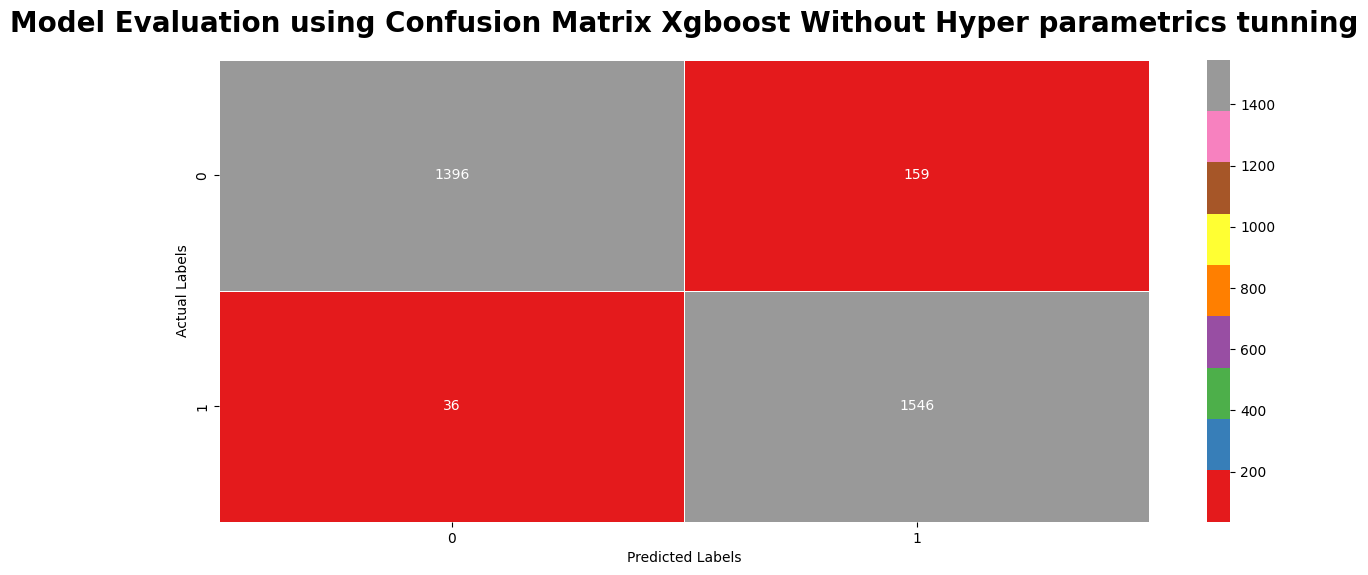

In [7]:
cm = confusion_matrix(y_test,y_test_pred_rfc)

plt.figure(figsize=(15,6))
sns.heatmap(data=cm, linewidth=.5, annot=True, fmt="g", cmap="Set1")
plt.title("Model Evaluation using Confusion Matrix Xgboost Without Hyper parametrics tunning",fontsize=20,pad=20,fontweight="black")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

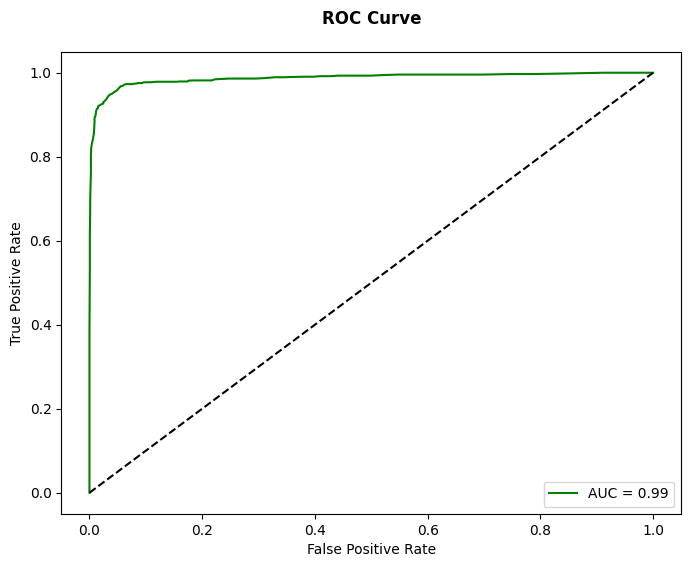

In [8]:
y_pred_proba = rfc.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"])])
df_actual_predicted.index = y_test.index


fpr, tpr, thresholds = roc_curve(df_actual_predicted["y_actual"], y_pred_proba)
auc = roc_auc_score(df_actual_predicted["y_actual"], y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",pad=20,fontweight="black")
plt.legend()
plt.show()

## Random Forest With Hyper parametrics tunning

Hyperparameter tuning diperlukan untuk:
- menemukan pengaturan optimal dari parameter eksternal dalam model machine learning,
- memastikan performa terbaik,
- mencegah overfitting atau underfitting,
- meningkatkan kemampuan model untuk menggeneralisasi pada data baru.

Pada tahap ini dipilih "Grid Search" karena dataset juga memiliki resource yang cukup baik, dan bisa diperoleh hyperparameter yang paling optimal

In [9]:
# asumsikan df_oversampled sudah siap dan merupakan DataFrame yang sesuai
X = Dataset_After_Preprocessing.drop('Exited', axis=1)
y = Dataset_After_Preprocessing['Exited'].astype(int)

# memisahkan data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# membuat model XGBoost# melakukan Grid Search untuk menemukan parameter terbaik untuk model
rfch = RandomForestClassifier()


param_grid  = {"max_depth":[3,4,5,6,7,8],
              "min_samples_split":[3,4,5,6,7,8],
              "min_samples_leaf":[3,4,5,6,7,8],
              "n_estimators": [50,70,90,100],
              "criterion":["gini","entropy"]}



In [10]:
grid_search = GridSearchCV(rfch, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train ,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [3],
                         'min_samples_leaf': [3], 'min_samples_split': [3],
                         'n_estimators': [50]})

In [11]:
# mencari parameter terbaik untuk XGBoost
best_parameters = grid_search.best_params_

print("Parameter terbaik untuk RandomForest yaitu :\n\n")
print(best_parameters)

Parameter terbaik untuk Random Forest Model yaitu:




{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 50}

In [12]:
# Inisialisasi objek RandomForestClassifier dengan parameter terbaik
rfch = RandomForestClassifier(**best_parameters)

# Latih model menggunakan data pelatihan
rfch.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=3, min_samples_split=3,
                       n_estimators=50)

In [13]:
# menghitung akurasi model
y_train_pred_rfch = rfch.predict(X_train)
y_test_pred_rfch = rfch.predict(X_test)

### Metric Evaluation

####  Accuracy, Precision, Recall, dan F1

In [14]:


# Menghitung dan mencetak metrik evaluasi untuk data training
acc_train_rfch = round(accuracy_score(y_train, y_train_pred_rfch) * 100, 2)
acc_test_rfch = round(accuracy_score(y_test, y_test_pred_rfch) * 100, 2)
f1_rfch = round(f1_score(y_test, y_test_pred_rfch, average="micro") * 100, 2)
recall_rfch = round(recall_score(y_test, y_test_pred_rfch, average="micro") * 100, 2)
precision_rfch = round(precision_score(y_test, y_test_pred_rfch, average="micro") * 100, 2)


y_score_rfch = rfch.predict_proba(X_test)[:,1] # Menggunakan probabilitas kelas positif
roc_auc_rfch = roc_auc_score(y_test, y_score_rfch)

# Cross-validation
cv_scores_rfch= cross_val_score(rfch, X_train, y_train, cv=5, scoring='accuracy')


In [15]:

print("__________________________________Hasil Evaluasi Model Random Forest Hyper Parametrics Tunning_________________________________________________")
print("Accuracy Score of Model on Training Data is =>",acc_train_rfch,"%")
print("Accuracy Score of Model on Testing Data  is =>",acc_test_rfch,"%")
print("F1 Score of the Model is =>",f1_rfch)
print("Recall Score of the Model is =>",recall_rfch)
print("Precision Score of the Model is =>",precision_rfch)
print("ROC AUC Score of the Model is =>", roc_auc_rfch)
print("Cross-validation Accuracy Scores:", cv_scores_rfch)
print("Mean Cross-validation Accuracy:", cv_scores_rfch.mean())
print("__________________________________________________________________________________________________________________________________________________")


__________________________________Hasil Evaluasi Model Random Forest Hyper Parametrics Tunning_________________________________________________
Accuracy Score of Model on Training Data is => 77.07 %
Accuracy Score of Model on Testing Data  is => 76.6 %
F1 Score of the Model is => 76.6
Recall Score of the Model is => 76.6
Precision Score of the Model is => 76.6
ROC AUC Score of the Model is => 0.8479678944394534
Cross-validation Accuracy Scores: [0.75727381 0.76165803 0.76923077 0.78158629 0.7688322 ]
Mean Cross-validation Accuracy: 0.767716221602232
__________________________________________________________________________________________________________________________________________________


- Kita dapat mengamati bahwa recall, precision, dan F1 Score semuanya sama, artinya model kita mencapai keseimbangan sempurna antara mengidentifikasi sampel positif (recall) dengan benar dan meminimalkan positif palsu (precision).
- Nilai untuk F1 score, Recall, dan Precision semuanya kurang lebih 0,7. Sehingga metric ini menunjukkan bahwa model tersebut mencapai akurasi yang baik dalam memprediksi kelas positif.

####  Confussion Matrix and ROC

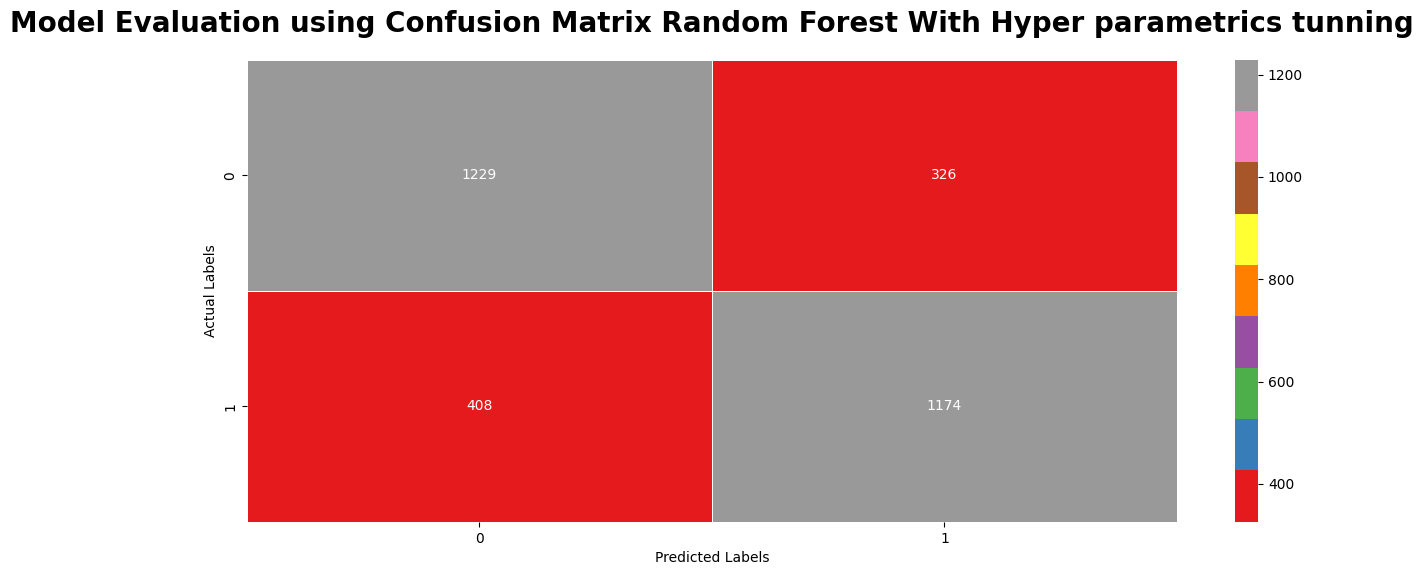

In [16]:
cm = confusion_matrix(y_test,y_test_pred_rfch)

plt.figure(figsize=(15,6))
sns.heatmap(data=cm, linewidth=.5, annot=True, fmt="g", cmap="Set1")
plt.title("Model Evaluation using Confusion Matrix Random Forest With Hyper parametrics tunning",fontsize=20,pad=20,fontweight="black")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

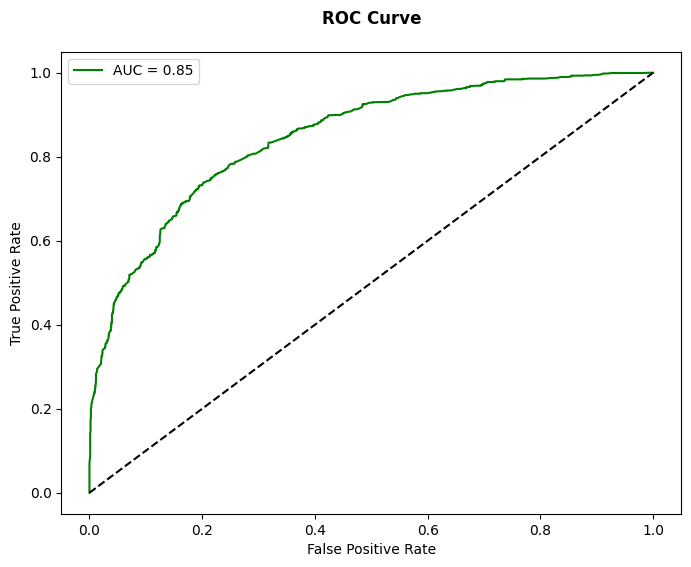

In [17]:
y_pred_proba = rfch.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"])])
df_actual_predicted.index = y_test.index


fpr, tpr, thresholds = roc_curve(df_actual_predicted["y_actual"], y_pred_proba)
auc = roc_auc_score(df_actual_predicted["y_actual"], y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",pad=20,fontweight="black")
plt.legend()
plt.show()

In [18]:
# Menyimpan variabel-variabel ke dalam dictionary
metrics_dict = {
    'model_rfc' : rfc,
    'acc_train_rfc': acc_train_rfc,
    'acc_test_rfc': acc_test_rfc,
    'f1_rfc': f1_rfc,
    'recall_rfc': recall_rfc,
    'precision_rfc': precision_rfc,
    'roc_auc_rfc': roc_auc_rfc,
    'model_rfch' : rfch,
    'cv_scores_rfc': cv_scores_rfc,
    'acc_train_rfch': acc_train_rfch,
    'acc_test_rfch': acc_test_rfch,
    'f1_rfch': f1_rfch,
    'recall_rfch': recall_rfch,
    'precision_rfch': precision_rfch,
    'roc_auc_rfch': roc_auc_rfch,
    'cv_scores_rfch': cv_scores_rfch
}

# Menyimpan dictionary ke dalam file pickle
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(metrics_dict, f)